In [1]:
%load_ext autoreload
%autoreload 2

import fastai
from fastai import *

from fastai.vision import *

In [2]:
fastai.__version__

'1.0.58.dev0'

In [3]:
lesson_dir_path = Path('lesson3-head-pose')
data_dir_path = untar_data(URLs.BIWI_HEAD_POSE, dest=lesson_dir_path)

In [4]:
tfms = get_transforms()

In [5]:
# Load camera calibration matrix; this appears to be the same for each subject
cal = np.loadtxt(data_dir_path/'01'/'rgb.cal', max_rows=3)

# Load only scene points of head
def load_p_s(path_pose):
    p_s = np.loadtxt(path_pose, skiprows=3)
    return np.expand_dims(p_s, 0).T

# Converts scene points to pixel points
def p_s2p_p(p_s, cal):
    p_prime = cal@p_s
    return p_prime[0:2,:1]/p_prime[2,0]

def get_p_p(path_img):
    p_s = load_p_s(path_img.parent/'_'.join(path_img.stem.split('_')[:2] + ['pose.txt']))
    p_p = p_s2p_p(p_s, cal)
    return torch.tensor([p_p[1,0],p_p[0,0]], dtype=torch.float)

In [6]:
valids = [f'{i:02}' for i in range(20, 25)]
def _is_valid(x):
    return x.parent.stem in valids

In [7]:
data = (PointsItemList.from_folder(data_dir_path)
                      .split_by_valid_func(_is_valid)
                      .label_from_func(get_p_p)
                      .transform(get_transforms(), tfm_y=True, size=(240, 320))
                      .databunch()
                      .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (12762 items)
x: PointsItemList
Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320)
y: PointsLabelList
ImagePoints (240, 320),ImagePoints (240, 320),ImagePoints (240, 320),ImagePoints (240, 320),ImagePoints (240, 320)
Path: /home/blaberj/fastai_course/lesson3-head-pose/biwi_head_pose;

Valid: LabelList (2916 items)
x: PointsItemList
Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320)
y: PointsLabelList
ImagePoints (240, 320),ImagePoints (240, 320),ImagePoints (240, 320),ImagePoints (240, 320),ImagePoints (240, 320)
Path: /home/blaberj/fastai_course/lesson3-head-pose/biwi_head_pose;

Test: None

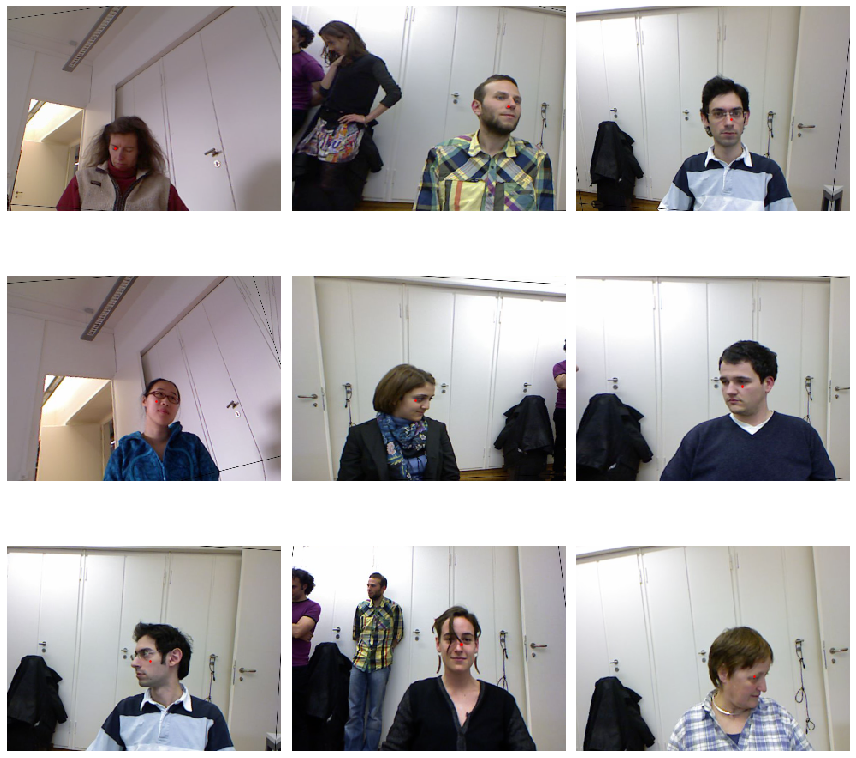

In [8]:
data.show_batch(3)

# Resnet34

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=mse, loss_func=mse)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


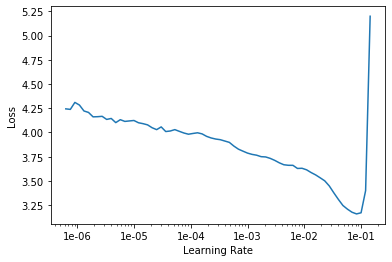

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.341561,0.007798,0.007798,00:58
1,0.065104,0.036087,0.036087,00:58
2,0.036363,0.017190,0.017190,01:01
3,0.015193,0.006327,0.006327,01:01
4,0.008957,0.005054,0.005054,00:58


In [12]:
learn.save('resnet34-base-size_half-stage_1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


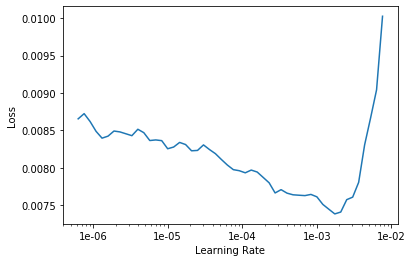

In [13]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(5, slice(1e-6,lr/10))

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.005341,0.004560,0.004560,00:56
1,0.003123,0.002637,0.002637,00:56
2,0.002138,0.001804,0.001804,00:55
3,0.001427,0.001776,0.001776,00:56
4,0.001243,0.001157,0.001157,01:00


In [15]:
learn.save('resnet34-base-size_half-stage_2')

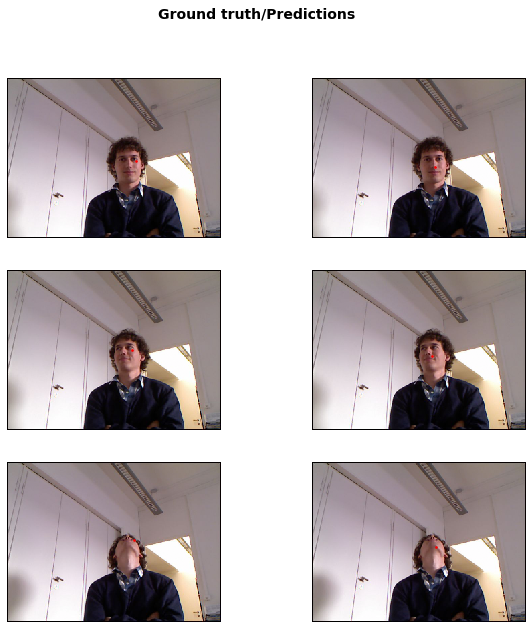

In [16]:
learn.show_results(rows=3, figsize=(10,10))